### Extract data & train/test sets 
* pretrain data: all black + which + combinations
    * Could supplemenet with more black/white from internet, and other jokes sources (reddit, jester) but overkill. 
    * Main goal is just to "warm up" a language/sentence model, generically. 


#### Check which pairs outperform their white cards baseline
  * NOTE: This is underpowered! (unless we were to use a very high min # of picks) 

  * Save this as another dataset, without train/test split ? 

Each row of the file represents a white card that was given to a player in a round and how it performed. It also contains information about the round like how long it took and what black card was dealt.
So columns that describe general round data will be exactly the same for all ten rows of that round. These rows are: fake_round_id, round_completion_seconds, round_skipped, black_card_text, and black_card_pick_num.
But columns that describe a property of the white card will change over the ten rows of that round. These rows are: white_card_text, won, and winning_index.


The columns:
* fake_round_id: a unique integer for every round. This is to help you separate one round from another to find which 10 cards were presented in every round.
* round_completion_seconds: the number of seconds it took for the user to pick a winner after being presented the cards for that round. You'll probably want to filter out users that decide too quickly by setting some minimum threshold for this. Some of these numbers can be insanely high as well since the user just left their browser open for hours or possibly days before picking a winner.
* round_skipped: we have a red button in the top right of the lab page that says "No Good Plays!". If a user clicks this button, round_skipped will be "True" and no white card will be marked as a winner.
* black_card_text: self explanatory.
* black_card_pick_num: The number of white cards that the black card requires. Generally 1, but will be 2 for black cards like "That's right, I killed _____. How, you ask? _____."
* white_card_text: self explanatory.
* won: True if this white card won the round.
* winning_index: This is for storing the order that the winning card(s) were picked in. If the white card didn't win, this will just contain a null value (NULL). If the card won and the black card was a normal "Pick 1" this will always be 0. But if the black card was a "Pick 2", one of the winners will be 0 and the other will be 1. This is how you figure out which blank in pick 2 black cards was meant to be filled by which winning white card. The first blank is filled by the 0 and the second one by the 1.

* sample groups (for test);

* https://stackoverflow.com/questions/44007496/random-sampling-with-pandas-data-frame-disjoint-groups
    ```
    from sklearn.model_selection import GroupShuffleSplit

    # Initialize the GroupShuffleSplit.
    gss = GroupShuffleSplit(n_splits=1, test_size=0.5)

    # Get the indexers for the split.
    idx1, idx2 = next(gss.split(df, groups=df.ids))

    # Get the split DataFrames.
    df1, df2 = df.iloc[idx1], df.iloc[idx2]
    ```

* https://hippocampus-garden.com/pandas_group_sample/
    ```
    sampled_users = np.random.choice(df["user_id"].unique(), 100)
    df_sampled = df.groupby('user_id').filter(lambda x: x["user_id"].values[0] in sampled_users)
    df_sampled["user_id"].nunique()
    ```

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import seaborn as sns
pd.set_option("display.precision", 4)
pd.set_option('display.width', 1024)
pd.set_option('display.max_colwidth', None)
%matplotlib inline 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score  
# https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.model_selection import GroupShuffleSplit

ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1)

In [3]:
# from sentence_transformers import SentenceTransformer, util ## versions error? 

In [4]:
LOAD_CSV = False#False ## load raw data from csv instead of parquet (which has had some cols dropped)
MIN_PAIR_FREQ = 4
SAVE_TRAIN_DATA = False#True

LOWERCASE_DATA = False
DROP_DOUBLES = True ## drop white cards with pick 2 options ; and their blacks. (TODO: analyze interesting pairs)
DROP_SKIPPED = True ## ignore rounds where skipped

Load data

* Note there are some near-duplicate cards (e.g. footballers - could minhash - https://github.com/chrisjmccormick/MinHash/blob/master/runMinHashExample.py , LSH/shingles : https://onestopdataanalysis.com/lsh/  (broken library?) , https://github.com/zyocum/dedup/blob/master/dedup.py ,

`Datasketch` https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/ ,
https://stackoverflow.com/questions/25114338/approximate-string-matching-using-lsh , 

SKLearn friendly?: http://ethen8181.github.io/machine-learning/recsys/content_based/lsh_text.html

`dedupe` library - https://github.com/dedupeio/dedupe

* Paraphrase mining using sentence bert - https://www.sbert.net/examples/applications/paraphrase-mining/README.html  (may be too semantic)

* Example: "10 football players with erections *barreling* towards you at full speed" - 10 football players with erections **barrelling** towards you at full speed."

Task modelling:
* Ranking = most accurate
* Regression/classification: can be done just over single cards, or between pairs. 
    * if pairs-wise: can use sentencebert/SNLI models (which assume pairs of sentences) - https://github.com/UKPLab/sentence-transformers
    
    
Examples:

* https://www.sbert.net/examples/training/sts/README.html#training-data
* https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py
* https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli_v2.py


* Keras example (not sentenceBert): https://keras.io/examples/nlp/semantic_similarity_with_bert/


* Interpretability tool : https://github.com/cdpierse/transformers-interpret

In [5]:
%%time
#### Original processing of data, before I saved it as a parquet for faster subsequent loading: 
if LOAD_CSV:
    df = pd.read_csv(DATA_PATH)
    
    ## remove punct/newlines
    df["white_card_text"] = df["white_card_text"].replace("\n", " ",regex=True).replace("\t", " ",regex=True) # .replace("\r", "")
    df["black_card_text"] = df["black_card_text"].replace("\n", " ",regex=True).replace("\t", " ",regex=True) # .replace("\r", "")

    ## add number within group - may not actually be the read order shown on screen!! 
    df['ID_index'] = df.groupby('fake_round_id').cumcount() + 1

    print(df[['black_card_text', 'black_card_pick_num', 'white_card_text',"fake_round_id"]].nunique())
    print(df.describe())
    
    ## save to disk in compressed, binary format
    df.drop(["winning_index"],axis=1).to_parquet('cah_lab_data.parquet')
#     df.drop(["winning_index"],axis=1).to_feather('cah_lab_data.feather')
    
else:  # load data saved in above code previously
    df = pd.read_parquet('cah_lab_data.parquet')
#     df= pd.read_feather('cah_lab_data.feather')

print(df.shape[0], "rows")
print(df.loc[df["round_skipped"]].shape[0], "rounds skipped")
print(df.nunique())
if DROP_SKIPPED:
    df = df.loc[~df["round_skipped"]]
df

2989550 rows
173830 rounds skipped
fake_round_id               298955
round_completion_seconds      1909
round_skipped                    2
black_card_text                650
black_card_pick_num              2
white_card_text               2128
won                              2
ID_index                        10
dtype: int64
CPU times: total: 2.66 s
Wall time: 2.14 s


,fake_round_id,round_completion_seconds,round_skipped,black_card_text,black_card_pick_num,white_card_text,won,ID_index
0,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,Going inside at some point because of the mosquitoes.,False,1
1,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,Being fat from noodles.,False,2
2,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,Letting this loser eat me out.,False,3
3,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,That chicken from Popeyes.®,False,4
4,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,A sorry excuse for a father.,False,5
...,...,...,...,...,...,...,...,...
2989545,298955,7613,False,Oh my god! _____ killed Kenny!,1,Breastfeeding a ten-year-old.,False,6
2989546,298955,7613,False,Oh my god! _____ killed Kenny!,1,Happy daddies with happy sandals.,False,7
2989547,298955,7613,False,Oh my god! _____ killed Kenny!,1,Jerking off to a 10-second RealMedia clip.,False,8
2989548,298955,7613,False,Oh my god! _____ killed Kenny!,1,Getting naked and watching Nickelodeon.,False,9


#### normalize \____ 's 
* Rememebr to do this if evaluating
* May not be needed!
    * We also do this for consistency when doing find and replace , and for cases where there's no ___ in the text

In [ ]:
df["has_"] = df["black_card_text"].str.contains("_{2,}")
### filter out cases with 2 blanks to fill ? 

df['black_card_text'] = df['black_card_text'].str.replace("_{2,}","__")
## https://stackoverflow.com/questions/47696401/replace-character-of-column-value-with-string-from-another-column-in-pandas


### Pick 2s
* Keep only subset for free text, and self join is slow.... 
* Keep only sample of combinations, as otherwise we get huuuge # combinations

In [ ]:
df_doubles = df.loc[df["black_card_pick_num"]>1].filter(['black_card_text', 'white_card_text',"won","fake_round_id"],axis=1).drop_duplicates().copy()

In [ ]:
df = df.loc[df["black_card_pick_num"]<2] ## keep non doubles only

# df[["id_black","id_white"]] = ord_enc.fit_transform(df[["black_card_text","white_card_text"]])
df["id_white"] = ord_enc.fit_transform(df["white_card_text"].values.reshape(-1, 1))

## df with all texts from data
white, black and combinations

In [9]:
# df_text = pd.concat([df["black_card_text"],
#                        df["white_card_text"],
#                     df_doubles['text'],df_doubles['black_card_text']]).drop_duplicates()

Fill in "punchlines" into blanks (___) (or add at end of text for cards without ___)

* NOTE: Previously I had tried a model with black and white text as 2 prompts (which meant the model needed to learn to fill in blanks); and a model of just the filled in answer (1 col). 
* Unclear what is "easier" to learn/model

* Note this doesn't handle cases with double blanks (it will just input the same punchline twice)

In [ ]:
df["has_"] = df["black_card_text"].str.contains("_{2,}",regex=True)

df['black_card_text'] = df['black_card_text'].str.replace("_{2,}","__",regex=True)
## https://stackoverflow.com/questions/47696401/replace-character-of-column-value-with-string-from-another-column-in-pandas
## https://datascience.stackexchange.com/questions/39345/how-to-replace-a-part-string-value-of-a-column-using-another-column
# Remove characters from one column based on string of another column

## remove "." from end of text
df["white_card_text"] = df["white_card_text"].str.replace("\.$", '',regex=True)
df['text'] = df.apply(lambda x:x['black_card_text'].replace("__", x['white_card_text']), axis=1)

## add answer at end of text, in cases where no ___ in black card
df.loc[(df["has_"]==False),"text"] = df["text"] +" " + df["white_card_text"] #+ "."

df['text'] = df['text'].str.replace("..",".",regex=False) ## fix double dots. Still levaes extra punct.. 

display(df)

##### Fit prior odds / encoder


In [11]:
assert df["won"].isna().sum()==0

In [12]:
df["won"].mean().round(2)

0.1

### check white prior as baseline model

* 21% win rate by picking most popular answer, on FILTERED Data
* On _full_ 3 million games (including different outcomes for same pair, i.e no filtering by # picks), _it does not better than random! _

In [13]:
df_white_prior = df.groupby(["white_card_text"], as_index=False)["won"].mean().rename(columns={"won":"white_prior"}).set_index("white_card_text")
df = df.join(df_white_prior,on="white_card_text",how="left")
prior = df["white_prior"].mean()
df["white_prior"] = df["white_prior"].fillna(prior)

print("Prior Acc:",df.sort_values("white_prior",ascending=False).groupby("fake_round_id").head(1)["won"].mean())

Prior Acc: 0.20897578443074608


### Filter (twice) by min pair count
* Also later by higher thresh

In [14]:
df["pair_count"] = df.groupby("text")["won"].transform("count") ## can be used to filter sentences occurring less than k times

df["white_count"] = df.groupby("white_card_text")["won"].transform("count")
df["black_count"] = df.groupby("black_card_text")["won"].transform("count")

In [15]:
int(df.shape[0])
df = df.loc[df["pair_count"]>=3] # 3?  +- could filter rounds with no win?  (code in previous notebook)
print(df.shape[0])

1949028


### get min count/cooccurences of sentence pairs & White
* Filter train +_ TEST for min K occurrences of a pair
* Filter games/rounds where positive was removed ? 

In [16]:
df["sum_won"] = df.groupby("text")["won"].transform("sum")
df["pair_prior"] = df.groupby("text")["won"].transform("mean")

### some top picks/combs

In [17]:
df.sort_values(by=["pair_prior"],ascending=False).head(12)

,fake_round_id,round_completion_seconds,round_skipped,black_card_text,black_card_pick_num,white_card_text,won,ID_index,has_,id_white,text,white_prior,pair_count,white_count,black_count,sum_won,pair_prior
663810,66382,18,False,What has been making life difficult at the nudist colony?,1,Gay thoughts,True,1,False,844.0,What has been making life difficult at the nudist colony? Gay thoughts,0.2609,3,1234,5870,3,1.0
673916,67392,4,False,"Match-maker, match-maker, make me a match. Find me __.",1,Thick Ukrainian ass,True,7,True,1940.0,"Match-maker, match-maker, make me a match. Find me Thick Ukrainian ass.",0.1916,4,1216,6010,4,1.0
353603,35361,19,False,And today's soup is Cream of __.,1,Capitalism,True,4,True,518.0,And today's soup is Cream of Capitalism.,0.1837,3,1339,6280,3,1.0
2961177,296118,10,False,"Well if you'll excuse me, gentlemen, I have a date with __.",1,A horse with no legs,True,8,True,139.0,"Well if you'll excuse me, gentlemen, I have a date with A horse with no legs.",0.1064,3,1241,6480,3,1.0
2539524,253953,8,False,"Match-maker, match-maker, make me a match. Find me __.",1,German dungeon porn,True,5,True,854.0,"Match-maker, match-maker, make me a match. Find me German dungeon porn.",0.2520,4,1246,6010,4,1.0
1064028,106403,18,False,"What has my life become? I'm jerking off to a video called ""co-ed absolutely destroyed by __.""",1,Cancer,True,9,True,517.0,"What has my life become? I'm jerking off to a video called ""co-ed absolutely destroyed by Cancer.""",0.1879,3,1288,6000,3,1.0
1516922,151693,6,False,Click Here for __!!!,1,Hillary Clinton's emails,True,3,True,990.0,Click Here for Hillary Clinton's emails!!!,0.1279,3,1204,6430,3,1.0
282237,28224,8,False,"I'm no doctor, but I'm pretty sure what you're suffering from is called ""__.""",1,The last season of Game of Thrones,True,8,True,1852.0,"I'm no doctor, but I'm pretty sure what you're suffering from is called ""The last season of Game of Thrones.""",0.1017,3,1318,6280,3,1.0
353406,35341,15,False,"IF you like __, YOU MIGHT BE A REDNECK.",1,Our dumb asshole president,True,7,True,1360.0,"IF you like Our dumb asshole president, YOU MIGHT BE A REDNECK.",0.1628,4,1278,5950,4,1.0
1431812,143182,9,False,"I'm just gonna stay in tonight. You know, Netflix and __.",1,Fisting,True,3,True,790.0,"I'm just gonna stay in tonight. You know, Netflix and Fisting.",0.2264,4,1272,6570,4,1.0


In [18]:
df.sort_values(by=["white_prior"],ascending=False).head(12)

,fake_round_id,round_completion_seconds,round_skipped,black_card_text,black_card_pick_num,white_card_text,won,ID_index,has_,id_white,text,white_prior,pair_count,white_count,black_count,sum_won,pair_prior
1440673,144068,11,False,"The secret to a lasting marriage is communication, communication, and __.",1,"Sluts, whores, and bitches",True,4,True,1593.0,"The secret to a lasting marriage is communication, communication, and Sluts, whores, and bitches.",0.275,7,1302,6070,3,0.4286
744071,74408,63,False,"In what's being hailed as a major breakthrough, scientists have synthesized __ in the lab.",1,"Sluts, whores, and bitches",True,2,True,1593.0,"In what's being hailed as a major breakthrough, scientists have synthesized Sluts, whores, and bitches in the lab.",0.275,4,1302,5840,2,0.5000
880140,88015,20,False,Why my mustache smell so bad?,1,"Sluts, whores, and bitches",True,1,False,1593.0,"Why my mustache smell so bad? Sluts, whores, and bitches",0.275,4,1302,5750,1,0.2500
1901136,190114,52,False,What makes life worth living?,1,"Sluts, whores, and bitches",False,7,False,1593.0,"What makes life worth living? Sluts, whores, and bitches",0.275,5,1302,5900,0,0.0000
2609031,260904,10,False,"To prepare for his upcoming role, Daniel Day-Lewis immersed himself in the world of __.",1,"Sluts, whores, and bitches",False,2,True,1593.0,"To prepare for his upcoming role, Daniel Day-Lewis immersed himself in the world of Sluts, whores, and bitches.",0.275,3,1302,6110,2,0.6667
1780039,178004,30,False,What made my first kiss so awkward?,1,"Sluts, whores, and bitches",True,10,False,1593.0,"What made my first kiss so awkward? Sluts, whores, and bitches",0.275,5,1302,6900,1,0.2000
578031,57804,10,False,"Welcome to Señor Frog's! Would you like to try our signature cocktail, ""__ on the Beach""?",1,"Sluts, whores, and bitches",False,2,True,1593.0,"Welcome to Señor Frog's! Would you like to try our signature cocktail, ""Sluts, whores, and bitches on the Beach""?",0.275,3,1302,6660,0,0.0000
687974,68798,26,False,Why do I hurt all over?,1,"Sluts, whores, and bitches",False,5,False,1593.0,"Why do I hurt all over? Sluts, whores, and bitches",0.275,3,1302,5940,1,0.3333
2167747,216775,11,False,We do not shake with our left hands in this country. That is the hand we use for __.,1,"Sluts, whores, and bitches",True,8,True,1593.0,"We do not shake with our left hands in this country. That is the hand we use for Sluts, whores, and bitches.",0.275,4,1302,6190,2,0.5000
823072,82308,6,False,"Just once, I'd like to hear you say ""Thanks, Mom. Thanks for __.""",1,"Sluts, whores, and bitches",False,3,True,1593.0,"Just once, I'd like to hear you say ""Thanks, Mom. Thanks for Sluts, whores, and bitches.""",0.275,4,1302,6180,0,0.0000


In [19]:
print(df.shape[0])
df = df.loc[df["pair_count"]>=MIN_PAIR_FREQ]
print(df.shape[0])
print(df.nunique())

1949028
1429296
fake_round_id               240182
round_completion_seconds      1650
round_skipped                    1
black_card_text                430
black_card_pick_num              1
white_card_text               1964
won                              2
ID_index                        10
has_                             2
id_white                      1964
text                        288765
white_prior                   1857
pair_count                      12
white_count                    213
black_count                    149
sum_won                          9
pair_prior                      40
dtype: int64


### Get Outperforming pairs target: 
Pairs where the white card does better than it's prior win rate
* Add +0.1 to smoothen. 
* Lacks statistical significance unless we were to filter bya ver high min count of pairs
* Binomal paired t-test distrib ? 

##### Get ourperforming pairs (vs white prior win rate)
* https://maxhalford.github.io/blog/target-encoding/. - smooth the ratio? 

In [20]:
df_grp = df.filter(['black_card_text', 'white_card_text', "pair_prior","pair_count","white_prior",'text',"white_count"],axis=1).drop_duplicates()
df_grp =df_grp.sort_values(["white_prior","pair_prior"],ascending=False)

# df_grp = df_grp.round(4)
df_grp.describe().round(2)

,pair_prior,pair_count,white_prior,white_count
count,288765.00,288765.00,288765.00,288765.00
mean,0.10,4.95,0.10,1251.69
std,0.15,1.16,0.05,58.05
min,0.00,4.00,0.01,26.00
25%,0.00,4.00,0.06,1228.00
50%,0.00,5.00,0.09,1252.00
75%,0.20,6.00,0.13,1276.00
max,1.00,15.00,0.27,2455.00


In [21]:
# df_grp.loc[df_grp["black_card_text"]=="What makes life worth living?"].drop_duplicates(subset="white_card_text").sort_values(["pair_count","pair_prior","white_prior"],ascending=False)
df_grp.loc[df_grp["black_card_text"]=="What makes life worth living?"].drop_duplicates(subset="white_card_text").sort_values(["pair_prior","white_prior"],ascending=False)

,black_card_text,white_card_text,pair_prior,pair_count,white_prior,text,white_count
568344,What makes life worth living?,Dying,1.00,6,0.1494,What makes life worth living? Dying,1305
1735731,What makes life worth living?,Masturbating,0.75,4,0.2561,What makes life worth living? Masturbating,1343
1211070,What makes life worth living?,Eating ass,0.75,4,0.2372,What makes life worth living? Eating ass,1248
129149,What makes life worth living?,Blowing my boyfriend so hard he shits,0.75,4,0.1559,What makes life worth living? Blowing my boyfriend so hard he shits,1257
327884,What makes life worth living?,Period poops,0.75,4,0.1492,What makes life worth living? Period poops,1280
...,...,...,...,...,...,...,...
515157,What makes life worth living?,The secret to truly resilient hair,0.00,6,0.0260,What makes life worth living? The secret to truly resilient hair,1231
23640,What makes life worth living?,Sanding off a man's nose,0.00,7,0.0246,What makes life worth living? Sanding off a man's nose,1303
1055043,What makes life worth living?,Sharpening a foam broadsword on a foam whetstone,0.00,5,0.0239,What makes life worth living? Sharpening a foam broadsword on a foam whetstone,1213
557093,What makes life worth living?,An emergency all-floor meeting on inclusion,0.00,4,0.0210,What makes life worth living? An emergency all-floor meeting on inclusion,1284


In [22]:
# df_grp
df_grp.sort_values(["pair_prior","white_prior"],ascending=False).head(10)

,black_card_text,white_card_text,pair_prior,pair_count,white_prior,text,white_count
84899,"My country, 'tis of thee, sweet land of __.","Sluts, whores, and bitches",1.0,5,0.2750,"My country, 'tis of thee, sweet land of Sluts, whores, and bitches.",1302
283889,"""This is madness!"" \n ""No. THIS IS __!""",A big black dick,1.0,4,0.2728,"""This is madness!"" \n ""No. THIS IS A big black dick!""",1228
666097,I love being a mom. But it's tough when my kids come home filthy from __. That's why there's Tide.®,A big black dick,1.0,4,0.2728,I love being a mom. But it's tough when my kids come home filthy from A big black dick. That's why there's Tide.®,1228
644015,"Unfortunately, no one can be told what __ is. You have to experience it for yourself.",The Asshole Destroyer 3000,1.0,4,0.2692,"Unfortunately, no one can be told what The Asshole Destroyer 3000 is. You have to experience it for yourself.",1252
1227772,One more thing. Watch out for Big Mike. They say he killed a man with __.,Three dicks at the same time,1.0,4,0.2665,One more thing. Watch out for Big Mike. They say he killed a man with Three dicks at the same time.,1246
623669,Personal foul: __. 15-yard penalty. Automatic first down.,Incest,1.0,4,0.2662,Personal foul: Incest. 15-yard penalty. Automatic first down.,1247
1299630,Lovin' you is easy 'cause you're __.,Anal,1.0,5,0.2652,Lovin' you is easy 'cause you're Anal.,1312
643604,"But before I kill you, Mr. Bond, I must show you __.",Dem titties,1.0,5,0.2630,"But before I kill you, Mr. Bond, I must show you Dem titties.",1247
48201,"Don't miss Rachel Ray's hit new show, Cooking with __.",Elf cum,1.0,4,0.2622,"Don't miss Rachel Ray's hit new show, Cooking with Elf cum.",1274
202107,"Goldfinger! He's the man, the man with __.",Elf cum,1.0,4,0.2622,"Goldfinger! He's the man, the man with Elf cum.",1274


In [23]:
df_grp["outperform_sub"] = df_grp["pair_prior"].sub(df_grp["white_prior"])
# df_grp["outperform_ratio"] = (df_grp["pair_prior"].sub(df_grp["white_prior"])).div(df_grp["white_prior"]) #ORIG
df_grp["outperform_ratio"] = (0.1 +df_grp["pair_prior"]).div(0.1 +df_grp["white_prior"])
df_grp["outperform_ratio_smooth"] = (0.1 +(df_grp["pair_prior"]).sub(df_grp["white_prior"])).div(df_grp["white_prior"]+0.1) ## 0.1 baseline smoothing
df_grp = df_grp.round(4)
df_grp.describe().round(2)

,pair_prior,pair_count,white_prior,white_count,outperform_sub,outperform_ratio,outperform_ratio_smooth
count,288765.00,288765.00,288765.00,288765.00,288765.00,288765.00,288765.00
mean,0.10,4.95,0.10,1251.69,0.00,1.00,0.53
std,0.15,1.16,0.05,58.05,0.14,0.70,0.71
min,0.00,4.00,0.01,26.00,-0.28,0.27,-0.47
25%,0.00,4.00,0.06,1228.00,-0.09,0.52,0.04
50%,0.00,5.00,0.09,1252.00,-0.05,0.65,0.30
75%,0.20,6.00,0.13,1276.00,0.09,1.41,0.87
max,1.00,15.00,0.28,2455.00,0.95,7.25,6.91


In [24]:
# df_grp.loc[df_grp["pair_prior"].round(4)==df_grp["white_prior"].round(4)].describe()
df_grp.describe().round(2)

,pair_prior,pair_count,white_prior,white_count,outperform_sub,outperform_ratio,outperform_ratio_smooth
count,288765.00,288765.00,288765.00,288765.00,288765.00,288765.00,288765.00
mean,0.10,4.95,0.10,1251.69,0.00,1.00,0.53
std,0.15,1.16,0.05,58.05,0.14,0.70,0.71
min,0.00,4.00,0.01,26.00,-0.28,0.27,-0.47
25%,0.00,4.00,0.06,1228.00,-0.09,0.52,0.04
50%,0.00,5.00,0.09,1252.00,-0.05,0.65,0.30
75%,0.20,6.00,0.13,1276.00,0.09,1.41,0.87
max,1.00,15.00,0.28,2455.00,0.95,7.25,6.91


In [25]:
# df_grp.loc[df_grp["pair_prior"]==df_grp["white_prior"]]
# df_grp.loc[df_grp["pair_prior"].round(4)==df_grp["white_prior"].round(4)]

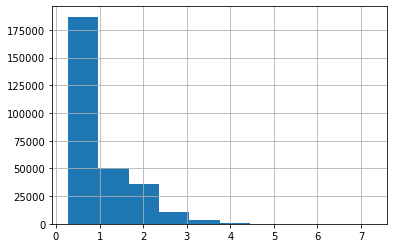

In [26]:
df_grp["outperform_ratio"].hist();

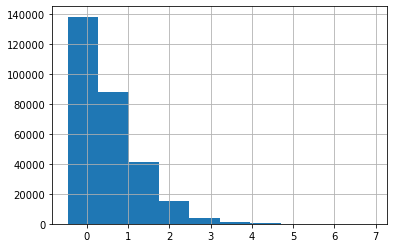

In [27]:
df_grp["outperform_ratio_smooth"].hist();

In [28]:
df_grp.sort_values(["outperform_ratio","pair_prior","white_prior"],ascending=False).head(10)

,black_card_text,white_card_text,pair_prior,pair_count,white_prior,text,white_count,outperform_sub,outperform_ratio,outperform_ratio_smooth
361415,What's a girl's best friend?,The hose,1.00,4,0.0517,What's a girl's best friend? The hose,1316,0.9483,7.2525,6.9118
660342,"Madam President, the asteroid is headed directly for Earth and there's only one thing that can stop it: __.",A time travel paradox,1.00,4,0.0655,"Madam President, the asteroid is headed directly for Earth and there's only one thing that can stop it: A time travel paradox.",1298,0.9345,6.6471,6.2514
200181,"And I would have gotten away with it, too, if it hadn't been for __!",Aaron Burr,1.00,4,0.0677,"And I would have gotten away with it, too, if it hadn't been for Aaron Burr!",1241,0.9323,6.5598,6.1562
610701,"As reparations for slavery, all African Americans will receive __.",A strong horse and enough rations for thirty days,0.75,4,0.0321,"As reparations for slavery, all African Americans will receive A strong horse and enough rations for thirty days.",1278,0.7179,6.4354,6.1925
334602,"When I was a kid, we used to play Cowboys and __.","Hot dog, the game you can eat, but only once",0.75,4,0.0374,"When I was a kid, we used to play Cowboys and Hot dog, the game you can eat, but only once.",1230,0.7126,6.1864,5.9142
353211,"When I am a billionaire, I shall erect a 50-foot statue to commemorate __.",A diverse group of female friends casually discussing the side effects of birth control,1.00,4,0.0788,"When I am a billionaire, I shall erect a 50-foot statue to commemorate A diverse group of female friends casually discussing the side effects of birth control.",1244,0.9212,6.1529,5.7122
732661,What brought the orgy to a grinding halt?,A diverse group of female friends casually discussing the side effects of birth control,1.00,4,0.0788,What brought the orgy to a grinding halt? A diverse group of female friends casually discussing the side effects of birth control,1244,0.9212,6.1529,5.7122
159067,Mom's to-do list: \n • Buy groceries \n • Clean up __ \n • Soccer practice,The economy,1.00,4,0.0794,Mom's to-do list: \n • Buy groceries \n • Clean up The economy \n • Soccer practice,1197,0.9206,6.1327,5.6903
408892,Members of New York's social elite are paying thousands of dollars just to experience __.,A 0.7 waist-to-hip ratio,0.75,4,0.0402,Members of New York's social elite are paying thousands of dollars just to experience A 0.7 waist-to-hip ratio.,1243,0.7098,6.0617,5.7748
756254,"When I pooped, what came out of my butt?",These awesome gadgets that track my every move,0.75,4,0.0419,"When I pooped, what came out of my butt? These awesome gadgets that track my every move",1265,0.7081,5.9903,5.6950


#### save output
* Keep alt targets/leaks

In [29]:
# df_grp.sample(frac=1).to_csv("cah_outperform_min6.csv.gz",index=False,compression="gzip")

#### Whites prior: 
* 20.5% accuracy on test set!!;
* 23% after min 3 filtering

In [30]:
df_white_prior = df.groupby(["white_card_text"], as_index=False)["won"].mean().rename(columns={"won":"white_prior"}).set_index("white_card_text")
df_test = df_test.join(df_white_prior,on="white_card_text",how="left")
prior = df_test["white_prior"].mean()
df_test["white_prior"] = df_test["white_prior"].fillna(prior)
print(df_test.shape[0],"test shape after join")
print("Prior Acc:",df_test.sort_values("white_prior",ascending=False).groupby("fake_round_id").head(1)["won"].mean())

NameError: name 'df_test' is not defined

### keep 1s (for train) ?
* MAY want to filter - e.g. min # cases of it being picked (+- keeping that for use for sample weight)
* Keep all data for now, (to allow for grouping by rounds if we want, since this is a ranking problem) 

* temp